<a href="https://colab.research.google.com/github/superpanditas/mobo/blob/main/MOBO_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objetivo: Desarrollar un modelo para pronosticar ventas futuras, utilizando las variables disponibles en el dataset

- Utilizaremos los lags
- dayofweek, dayofyear
- rolling mean

Y evaluaremos usando RMSE pues nos da el error en terminos de la variable a pronostiar, facilitando la interpretación

In [61]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [62]:
df_sales = pd.read_csv('/content/dataset_ventas-2.csv')
df_sales.head()

,ID Producto,ID Tienda,Fecha de Venta,Cantidad Vendida,Precio Unitario,Categoría de Producto,Ubicación de Tienda,Promoción o Descuento,Estacionalidad,Método de Pago,Nivel de Inventario
0,Producto_43,Tienda_2,2023-02-13,81,498.48,Deportes,Zona Este,1,1,Efectivo,10
1,Producto_22,Tienda_1,2023-04-19,25,204.46,Juguetes,Zona Norte,0,1,Crédito,100
2,Producto_27,Tienda_6,2022-05-29,13,253.30,Alimentos,Zona Este,1,0,Crédito,100
3,Producto_6,Tienda_6,2022-08-15,67,134.23,Electrónica,Zona Norte,0,1,Efectivo,50
4,Producto_1,Tienda_5,2023-02-02,21,329.80,Alimentos,Zona Este,1,0,Efectivo,300


In [63]:
features = ['Fecha de Venta', 'ID Producto', 'Cantidad Vendida', 'Promoción o Descuento', 'Estacionalidad']

df_sales['Fecha de Venta'] = pd.to_datetime(df_sales['Fecha de Venta'],
                                            format='%Y-%m-%d')

start_date = df_sales['Fecha de Venta'].min()
end_date = df_sales['Fecha de Venta'].max()
dates = pd.date_range(start=start_date, end=end_date, freq='D')
# stores = df_sales['ID Store'].nunique()
producto = df_sales['ID Producto'].unique()

sheet = pd.MultiIndex.from_product([dates, producto], names=['Fecha de Venta','ID Producto'])
sheet_dates = pd.DataFrame(index=sheet).reset_index()

df_sales_daily = pd.merge(sheet_dates, df_sales[features], on=['Fecha de Venta', 'ID Producto'], how='left')

df_sales_daily.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37676 entries, 0 to 37675
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Fecha de Venta         37676 non-null  datetime64[ns]
 1   ID Producto            37676 non-null  object        
 2   Cantidad Vendida       10000 non-null  float64       
 3   Promoción o Descuento  10000 non-null  float64       
 4   Estacionalidad         10000 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 1.4+ MB


In [64]:
df_sales_daily = df_sales_daily.sort_values(by=['ID Producto', 'Fecha de Venta'])
df_sales_daily['Cantidad Vendida'] = df_sales_daily.groupby('ID Producto')['Cantidad Vendida'].fillna(0)
df_sales_daily['Promoción o Descuento'] = df_sales_daily.groupby('ID Producto')['Promoción o Descuento'].fillna(0)
df_sales_daily['Estacionalidad'] = df_sales_daily.groupby('ID Producto')['Estacionalidad'].fillna(0)


# df_sales_daily['Cantidad Vendida'] = df_sales_daily.groupby('ID Producto')['Cantidad Vendida'].fillna(method='bfill')
# df_sales_daily['Cantidad Vendida'] = df_sales_daily.groupby('ID Producto')['Cantidad Vendida'].fillna(method='ffill')
# df_sales_daily['Promoción o Descuento'] = df_sales_daily.groupby('ID Producto')['Promoción o Descuento'].fillna(method='bfill')
# df_sales_daily['Estacionalidad'] = df_sales_daily.groupby('ID Producto')['Estacionalidad'].fillna(method='bfill')

df_sales_daily.head()

<ipython-input-64-fcdb11382ac2>:2: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df_sales_daily['Cantidad Vendida'] = df_sales_daily.groupby('ID Producto')['Cantidad Vendida'].fillna(0)
<ipython-input-64-fcdb11382ac2>:3: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df_sales_daily['Promoción o Descuento'] = df_sales_daily.groupby('ID Producto')['Promoción o Descuento'].fillna(0)
<ipython-input-64-fcdb11382ac2>:4: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Ser

,Fecha de Venta,ID Producto,Cantidad Vendida,Promoción o Descuento,Estacionalidad
4,2022-01-01,Producto_1,0.0,0.0,0.0
59,2022-01-02,Producto_1,0.0,0.0,0.0
110,2022-01-03,Producto_1,0.0,0.0,0.0
161,2022-01-04,Producto_1,0.0,0.0,0.0
214,2022-01-05,Producto_1,0.0,0.0,0.0


In [65]:
# df_sales_daily.info()
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np

data_p = df_sales_daily[df_sales_daily['ID Producto'] == 'Producto_20']['Cantidad Vendida']

autocorr_values = acf(data_p, fft=True, nlags=365)
lags = np.arange(len(autocorr_values))
autocorr_df = pd.DataFrame({'Lag': lags, 'Autocorrelation': autocorr_values})
autocorr_df_sorted = autocorr_df.sort_values('Autocorrelation', ascending=False)
# autocorr_df_sorted = autocorr_df.reindex(autocorr_df['Autocorrelation'].abs().sort_values(ascending=False).index)

autocorr_df_sorted.head(10)
# data.plot()

,Lag,Autocorrelation
0,0,1.000000
1,1,0.077936
133,133,0.075032
291,291,0.073723
95,95,0.068772
142,142,0.067776
33,33,0.064051
11,11,0.062761
149,149,0.062057
325,325,0.061914


In [80]:
lags = [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
        335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350,
        351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365]
for lag_n in lags:
  df_sales_daily[f'lag_{lag_n}'] = df_sales_daily.groupby(['ID Producto'])['Cantidad Vendida'].shift(lag_n)


In [81]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_sales_daily['ID encoded'] = le.fit_transform(df_sales_daily['ID Producto'])
df_sales_daily.tail()

,Fecha de Venta,ID Producto,Cantidad Vendida,Promoción o Descuento,Estacionalidad,lag_30,lag_31,lag_32,lag_33,lag_34,...,lag_350,lag_351,lag_352,lag_353,lag_354,lag_355,lag_356,lag_357,lag_358,lag_359
37626,2023-12-30,Producto_27,54.0,0.0,0.0,0.0,36.0,0.0,0.0,79.0,...,0.0,0.0,98.0,63.0,91.0,2.0,54.0,0.0,0.0,0.0
37651,2023-12-30,Producto_26,88.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,79.0,0.0,0.0,0.0,0.0
37650,2023-12-30,Producto_26,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,79.0,0.0,0.0,0.0
37653,2023-12-30,Producto_7,0.0,0.0,0.0,0.0,0.0,0.0,93.0,0.0,...,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37671,2023-12-30,Producto_9,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,64.0


In [88]:
df_sales_daily = df_sales_daily.sort_values('Fecha de Venta')
data = df_sales_daily.set_index(['Fecha de Venta', 'ID Producto'])

FEATURE = ['ID encoded', 'Promoción o Descuento', 'Estacionalidad', 'lag_30', 'lag_31',
           'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36', 'lag_37', 'lag_38', 'lag_39', 'lag_40',
           'lag_335', 'lag_336', 'lag_337', 'lag_338', 'lag_339', 'lag_340', 'lag_341', 'lag_342', 'lag_343',
           'lag_344', 'lag_345', 'lag_346', 'lag_347', 'lag_348', 'lag_349','lag_350', 'lag_351',
           'lag_352', 'lag_353', 'lag_354', 'lag_355', 'lag_356', 'lag_357', 'lag_358', 'lag_359', 'lag_360',
           'lag_361', 'lag_362', 'lag_363', 'lag_364', 'lag_365']

TARGET = ['Cantidad Vendida']

data_train = data['2023-02-01':'2023-06-30']
data_test = data['2023-12-01':'2023-12-31']

x_train, y_train = data_train[FEATURE], data_train[TARGET]
x_test, y_test = data_test[FEATURE], data_test[TARGET]

param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'lambda': [0, 1],
    'alpha': [0, 1]
}

random_search = RandomizedSearchCV(estimator=xgb.XGBRegressor(),
                                   param_distributions=param_dist,
                                   n_iter=50,
                                   cv=3,
                                   scoring='neg_mean_squared_error',
                                   random_state=5)

random_search.fit(x_train, y_train)
print("Best Parameters: ", random_search.best_params_)


Best Parameters:  {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'lambda': 1, 'gamma': 0, 'colsample_bytree': 1.0, 'alpha': 1}


In [89]:
# best parameters
best_params = random_search.best_params_
# best model
model_best = xgb.XGBRegressor(**best_params)
# train model
model_best.fit(x_train, y_train)
# forecasting ...
y_pred = model_best.predict(x_test)

In [90]:
import numpy as np
print("Best Model MSE: ", mean_squared_error(y_test, y_pred))
print("Best Model RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Best Model MSE:  385.0385523136414
Best Model RMSE:  19.62239924967488


In [91]:
feature_importances = model_best.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_importances
})

importance_df.sort_values('Importance', ascending=False).head(10)

,Feature,Importance
2,Estacionalidad,0.382182
1,Promoción o Descuento,0.231694
4,lag_31,0.011122
25,lag_346,0.011108
33,lag_354,0.010942
37,lag_358,0.010939
8,lag_35,0.010688
27,lag_348,0.010602
7,lag_34,0.010580
34,lag_355,0.010575


<ipython-input-92-64c2eef69f43>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['pred'] = y_pred
<ipython-input-92-64c2eef69f43>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['pred'] = data_test['pred'].round(0)


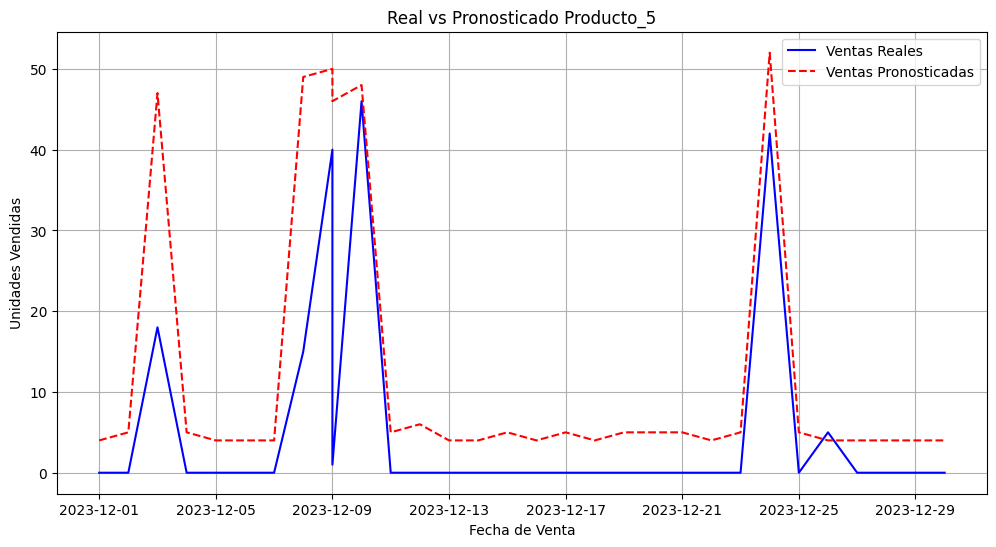

In [92]:
data_test['pred'] = y_pred
data_test['pred'] = data_test['pred'].round(0)

productos_pred = data_test.reset_index()
productos_pred = productos_pred[['Fecha de Venta', 'ID Producto', 'Cantidad Vendida', 'pred']]

producto = 'Producto_5'
productos_pred_flt = productos_pred[productos_pred['ID Producto'] == producto]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(productos_pred_flt['Fecha de Venta'], productos_pred_flt['Cantidad Vendida'], label='Ventas Reales', color='blue')
plt.plot(productos_pred_flt['Fecha de Venta'], productos_pred_flt['pred'], label='Ventas Pronosticadas', color='red', linestyle='--')

plt.title(f'Real vs Pronosticado {producto}')
plt.xlabel('Fecha de Venta')
plt.ylabel('Unidades Vendidas')
plt.legend()
plt.grid(True)
plt.show()


In [74]:
productos_pred_agg = productos_pred.groupby(['ID Producto']).agg({
    'Cantidad Vendida':'sum',
    'pred':'sum'
}).reset_index()

In [75]:
productos_pred_agg['diff'] = productos_pred_agg['pred'] - productos_pred_agg['Cantidad Vendida']
productos_pred_agg.sort_values('diff')

,ID Producto,Cantidad Vendida,pred,diff
46,Producto_6,931.0,543.0,-388.0
25,Producto_32,629.0,402.0,-227.0
49,Producto_9,518.0,357.0,-161.0
10,Producto_19,570.0,412.0,-158.0
3,Producto_12,709.0,554.0,-155.0
20,Producto_28,609.0,455.0,-154.0
23,Producto_30,602.0,452.0,-150.0
5,Producto_14,597.0,451.0,-146.0
34,Producto_40,672.0,549.0,-123.0
15,Producto_23,419.0,319.0,-100.0
